# Monte carlo technique in reinforcement learning

#### In this article I will attempt to explain application of MonteCarlo technique on Frozen Lake environment in openai Gym.

Monte Carlo is a set of techniques, where we attempt to find how the system works by 
making random sampling, and in some way averaging the results.

Due to the law of large numbers, our results should converge asymptotically to the function describing the system.

##### There are multiple ways of making random sampling, in this case the constraints of the model:

* State transition only depend on current state and action
* Don't need prior knowledge of state transition probabilities or rewards.
* Sampling happens from complete episodes.
* Episodes must terminate.
* States are observable

##### How the model works:

```
Repeat until episode terminates:
    Take a random action based on epsilon-greedy policy
    (a random action by epsilon probability else action by greedy policy)
    Append State-Action pair to episode history
Get episode reward
In reversed order from episode history for each state(S),action(A) pair:
    Append reward to returns G(S,A) = reward 
    (in case a State-Action pair visited multiple times, the lowest value will count)
    Decrease reward by gamma: reward = gamma * reward
For each visited State-Acion pair:
    Increase the number of visits by one: N(S,a) += 1
    Set the new running average value V(S,a) by appending returns G(S,a)
    as V(S,a) = V(S,a) + (G(S,a)-V(S,a))/N(S,a)

```
##### Greedy policy: 

From all possible Action **A** in given State **S**, choose **A** where **V(S,A)** is highest

<img src="https://raw.githubusercontent.com/oomti/100daysofMLcode/master/Move37/images/state-action.bmp">

### The code step by step:

Gym is the library which includes our test environment.

You can install gym with

```python
!pip install gym  
```
First import the libraries we are using,

```python
import gym
import numpy
import matplotlib as mpl
import matplotlib.pyplot as plt
```

We instantiate the FrozenLake8x8 environment object in gym

```python
environment = gym.make("FrozenLake8x8-v0") 
```
 
Reset the object to initial position

```python
environment.reset() 
```

We can render this environment in ascii format, in a text grid:

```python
environment.render()
```

Resulting in 


```
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
```




The core of our algorithm are 2 **arrays**, storing **state-action values**, and storing the **number of visits** for each state-action pair. We also need two temporary tables, which store the returns for visited state action pairs, and a helper table, which store if a state-action pair is being visited.

```python
class mcQTable:
    def __init__(self, number_Actions, number_States):
        self.nA=number_Actions
        self.nS=number_States
        self.stateActionValue = numpy.zeros((number_States, number_Actions))
        self.stateActionCount = numpy.ones((number_States, number_Actions))
        self.stateActionReturns = numpy.zeros((number_States, number_Actions))
        self.stateActionTraversed = numpy.zeros((number_States, number_Actions))
        self.totalCount = 0 #Number of tests done using MonteCarlo methods for averaging
```


I need a class **method** which **gets** an **action** based on **epsilon-greedy policy**, given a state.
I have wrapped it in a condition, that if all the values of actions in a given state are equal choose one randomly

```python
    def get_policy(self,state,epsilon):
            if numpy.amin(self.stateActionValue[state]) != numpy.amax(self.stateActionValue[state]):
                probability = numpy.ones(self.nA) * epsilon/(self.nA-1)
                positionMax = numpy.argmax(self.stateActionValue[state])
                probability[positionMax] = 1-epsilon
                return numpy.random.choice(self.nA, p=probability)
            else:
                return numpy.random.choice(self.nA)
```
I also need a **method** which updates the **value-state map** based on the **episode history**.
The policy could be updated by different choices: 
* We could count every visit on a given state-action pair, or only the first visit
* We could make a weighted average of returns, or make a simple rolling average

```python
    def update_policy(self, episode, reward, gamma):
        self.stateActionReturns *= 0
        self.stateActionTraversed *= 0
        for (state, action) in numpy.flip(episode,axis=0):
            self.stateActionReturns[state,action] = reward
            self.stateActionTraversed[state,action] = 1
            reward *= gamma
        self.stateActionCount +=self.stateActionTraversed
        self.stateActionValue += numpy.divide( \
                                            self.stateActionReturns \
                                            - self.stateActionValue\
                                            ,self.stateActionCount)
        self.stateActionValue = numpy.where(\
                                            self.stateActionTraversed\
                                            ,self.stateActionValue \
                                            + numpy.divide( \
                                                ( self.stateActionReturns  \
                                                - self.stateActionValue \
                                                ),self.stateActionCount) \
                                            ,self.stateActionValue)
```

We need a function, that walks our environment based on epsilon greedy policy, and returns the history.
Named it **shoot**, as the the function walks the state-action field as lightning seeks it's path.

```python
def shoot(env, qTable,epsilon):
    #A function to create a whole episode, as the lightning strikes
    done = False
    episodeHistory = []
    totalReward = 0
    state=env.reset()
    while not done:
        #Get the action
        action = qTable.get_policy(state,epsilon)
        
        episodeHistory.append([state,action])
        
        (state, reward, done, info) = env.step(action)
        
        totalReward += reward
    
    #Give a negative reward, if the run is not successful
    
    if totalReward == 0:
        totalReward = -1
        
    return (episodeHistory, totalReward)
```
<img src="https://raw.githubusercontent.com/oomti/100daysofMLcode/master/Move37/images/grid.bmp">

Having defined all our core functions , now we want to **iterate episodes**.
We have a wrapper function, which creates an episode and updates the state-action value table.
For testing purposes, I'm saving the resulting rewards from each episode, so I can check the gradual change of the success rate.

```python
def monteCarloTest(env,qTable,N,epsilon=1,gamma=0.95):
    rewards=numpy.zeros(N)
    for i in range(N):
        epsilon*=0.999
        (episode, rewards[i])=shoot(env, qTable,epsilon)
        qTable.update_policy(episode, rewards[i],gamma)
    
    return rewards
```

After iteratively correcting errors from the code, some features of the results are presented below.

<img src="https://raw.githubusercontent.com/oomti/100daysofMLcode/master/Move37/images/Success_rate.png">

<img src="https://raw.githubusercontent.com/oomti/100daysofMLcode/master/Move37/images/Value_map_combined.png">

<img src="https://raw.githubusercontent.com/oomti/100daysofMLcode/master/Move37/images/Value_map.png">

<img src="https://raw.githubusercontent.com/oomti/100daysofMLcode/master/Move37/images/Number_of_visits.png">
<img src="https://raw.githubusercontent.com/oomti/100daysofMLcode/master/Move37/images/Policy_map.png">
<img src="https://raw.githubusercontent.com/oomti/100daysofMLcode/master/Move37/images/Sample.png">
<img src="">
References:

https://www.kth.se/social/files/58b941d5f276542843812288/RL04-Monte-Carlo.pdf

https://oneraynyday.github.io/ml/2018/05/24/Reinforcement-Learning-Monte-Carlo/#example-cliff-walking

In [67]:
import gym
import numpy
import matplotlib as mpl
import matplotlib.pyplot as plt



In [68]:
environment = gym.make("FrozenLake8x8-v0")
environment.reset()

environment.render()
print(environment.action_space, environment.observation_space)
print(environment.env.nA, environment.env.nS)
size= int(environment.env.nS**(.5))
print(size)


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
Discrete(4) Discrete(64)
4 64
8


In [69]:
#defining parameters

epsilon = 1 
gamma = 0.95


In [85]:
class mcQTable:
    def __init__(self, number_Actions, number_States):
        self.nA=number_Actions
        self.nS=number_States
        self.stateActionValue = numpy.zeros((number_States, number_Actions))
        self.stateActionCount = numpy.ones((number_States, number_Actions))
        self.stateActionReturns = numpy.zeros((number_States, number_Actions))
        self.stateActionTraversed = numpy.zeros((number_States, number_Actions))
        self.totalCount = 0 #Number of tests done using MonteCarlo methods for averaging
        
    def get_policy(self,state,epsilon):
        if numpy.amin(self.stateActionValue[state]) != numpy.amax(self.stateActionValue[state]):
            probability = numpy.ones(self.nA) * epsilon/(self.nA-1)
            positionMax = numpy.argmax(self.stateActionValue[state])
            probability[positionMax] = 1-epsilon
            return numpy.random.choice(self.nA, p=probability)
        else:
            return numpy.random.choice(self.nA)
        
        
    def update_policy(self, episode, reward, gamma):
        self.stateActionReturns *= 0
        self.stateActionTraversed *= 0
        for (state, action) in numpy.flip(episode,axis=0):
            self.stateActionReturns[state,action] = reward
            self.stateActionTraversed[state,action] = 1
            reward *= gamma
        self.stateActionCount +=self.stateActionTraversed
        self.stateActionValue += numpy.divide(self.stateActionReturns - self.stateActionValue,self.stateActionCount)
        self.stateActionValue = numpy.where(self.stateActionTraversed\
                                            ,self.stateActionValue \
                                            + numpy.divide( \
                                                (self.stateActionReturns  \
                                                    - self.stateActionValue) \
                                                ,self.stateActionCount) \
                                            ,self.stateActionValue)


def shoot(env, qTable,epsilon):
    #A function to create a whole episode, as the lightning strikes
    done = False
    episodeHistory = []
    totalReward = 0
    state=env.reset()
    while not done:
        #Get the action
        action = qTable.get_policy(state,epsilon)
        
        episodeHistory.append([state,action])
        
        (state, reward, done, info) = env.step(action)
        
        totalReward += reward
    
    #Give a negative reward, if the run is not successful
    
    if totalReward == 0:
        totalReward = -1
        
    return (episodeHistory, totalReward)


def monteCarloTest(env,qTable,N,epsilon=1,gamma=0.97):
    rewards=numpy.zeros(N)
    for i in range(N):
        epsilon*=0.9995
        (episode, rewards[i])=shoot(env, qTable,epsilon)
        qTable.update_policy(episode, rewards[i],gamma)
    
    return rewards
#----------------------------------------------------------------
# Additional functions
def trajectory(history):
    trajectoryMap=numpy.zeros(environment.env.nS)
    size=int( environment.env.nS ** (1/2) )
    
    for (state,action) in history:
        trajectoryMap[state] += 1
    return trajectoryMap.reshape((size,size))
    
def testSuccessRate(qTable,env,N):
    successCount = 0
    numberOfSteps=[]
    for i in range(N):
        (trajectory, reward) = shoot(env,qTable,epsilon = 0)
        if reward > 0:
            successCount+=1
            numberOfSteps.append(len(trajectory))
    return successCount, numberOfSteps
    
    

In [86]:


QTable = mcQTable(environment.env.nA, environment.env.nS)


In [87]:
rewards=monteCarloTest(environment,QTable,100000,epsilon=1,gamma=0.95)

In [88]:
divisor=numpy.arange(len(rewards))
epsilonArray=0.9995 ** divisor

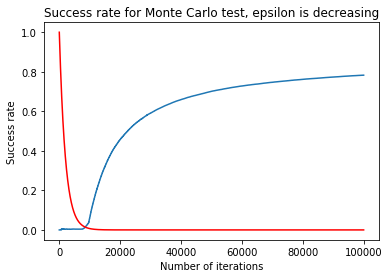

In [89]:

plt.plot(numpy.divide(numpy.cumsum((rewards+1)/2), divisor+1))
plt.plot(epsilonArray, color="red", label="epsilon")
plt.title("Success rate for Monte Carlo test, epsilon is decreasing")
plt.ylabel("Success rate")
plt.xlabel("Number of iterations")
plt.show()

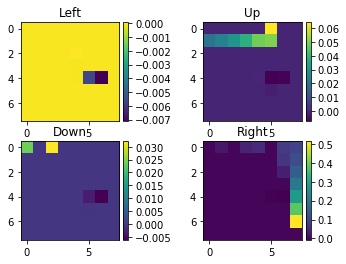

In [90]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax= plt.subplots(2,2)
# 0 - left
# 1 - down
# 2 -right
# 3 - up
vMax=numpy.max(QTable.stateActionValue)
ax[0,0].set_title("Left")
im1 = ax[0,0].imshow(numpy.log(numpy.reshape([element[0] for element in QTable.stateActionValue],(8,8))+1))
ax[0,1].set_title("Up")
im2 = ax[0,1].imshow(numpy.log(numpy.reshape([element[3] for element in QTable.stateActionValue],(8,8))+1))
ax[1,0].set_title("Down")
im3 = ax[1,0].imshow(numpy.log(numpy.reshape([element[1] for element in QTable.stateActionValue],(8,8))+1))
ax[1,1].set_title("Right")
im4 = ax[1,1].imshow(numpy.log(numpy.reshape([element[2] for element in QTable.stateActionValue],(8,8))+1))


divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical');

divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical');

divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical');
plt.show()

(array([54.,  5.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.]),
 array([-0.00609343,  0.06198502,  0.13006346,  0.19814191,  0.26622036,
         0.3342988 ,  0.40237725,  0.4704557 ,  0.53853414,  0.60661259,
         0.67469104]),
 <a list of 10 Patch objects>)

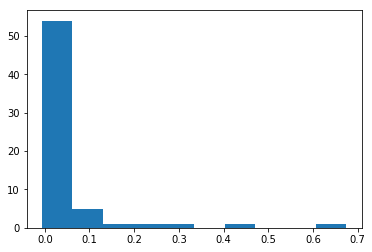

In [91]:
plt.hist(numpy.ravel(numpy.max(QTable.stateActionValue,axis=1)))

 (value of action) 
 
 Direction of action: 
 
 | Left | Up    | 
 |------|-------| 
 | Down | Right |


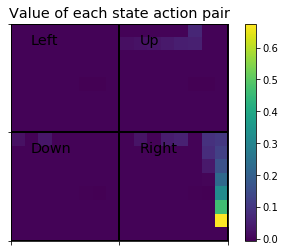

In [92]:
# 0 - left
# 1 - down
# 2 -right
# 3 - up


plt.imshow(numpy.concatenate(
    ((numpy.concatenate(
        (
            (numpy.reshape([element[0] for element in QTable.stateActionValue],(8,8))),
            (numpy.reshape([element[1] for element in QTable.stateActionValue],(8,8)))
        ),
        axis=0
    )),
    (numpy.concatenate(
        (
            (numpy.reshape([element[3] for element in QTable.stateActionValue],(8,8))),
            (numpy.reshape([element[2] for element in QTable.stateActionValue],(8,8)))
        ),
        axis=0
    ))),
    axis=1
    ))
plt.colorbar()
print(" (value of action) \n \n Direction of action: \n \n | Left | Up    | \n |------|-------| \n | Down | Right |")
plt.title("Value of each state action pair", fontsize = "x-large")
plt.grid(b=True,color="black", which='both', axis='both',linewidth=2)
plt.text(1,1, "Left",fontsize = "x-large")
plt.text(9,9, "Right",fontsize = "x-large")
plt.text(1,9, "Down",fontsize = "x-large")
plt.text(9,1, "Up",fontsize = "x-large")
plt.xticks(numpy.arange(-.5,size*2,8),[])
plt.yticks(numpy.arange(-.5,size*2,8),[])

plt.show()

log (number of counts) 
 
 Direction of action: 
 
 | Left | Up    | 
 |------|-------| 
 | Down | Right |


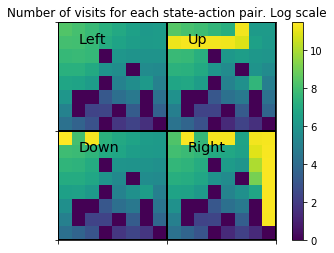

In [93]:
plt.imshow(numpy.concatenate(
    ((numpy.concatenate(
        (
            numpy.log(numpy.reshape([element[0] for element in QTable.stateActionCount],(8,8))),
            numpy.log(numpy.reshape([element[1] for element in QTable.stateActionCount],(8,8)))
        ),
        axis=0
    )),
    (numpy.concatenate(
        (
            numpy.log(numpy.reshape([element[3] for element in QTable.stateActionCount],(8,8))),
            numpy.log(numpy.reshape([element[2] for element in QTable.stateActionCount],(8,8)))
        ),
        axis=0
    ))),
    axis=1
    ))
plt.colorbar()
print("log (number of counts) \n \n Direction of action: \n \n | Left | Up    | \n |------|-------| \n | Down | Right |")
plt.title("Number of visits for each state-action pair. Log scale")
plt.grid(b=True,color="black", which='both', axis='both',linewidth=2)
plt.xticks(numpy.arange(-.5,size*2,8),[])
plt.yticks(numpy.arange(-.5,size*2,8),[])
plt.text(1,1, "Left",fontsize = "x-large")
plt.text(9,9, "Right",fontsize = "x-large")
plt.text(1,9, "Down",fontsize = "x-large")
plt.text(9,1, "Up",fontsize = "x-large")
plt.show()

Policy map 
 # 0 - left 
 # 1 - down 
 # 2 -right 
 # 3 - up


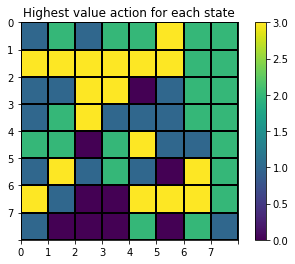

In [94]:
size=int(QTable.nS**(.5))
array=numpy.reshape([QTable.get_policy(i,0) for i in range(QTable.nS)],(size,size))  
plt.imshow(array)
# 0 - left
# 1 - down
# 2 -right
# 3 - up
plt.colorbar()

print("Policy map \n # 0 - left \n # 1 - down \n # 2 -right \n # 3 - up")
plt.title("Highest value action for each state")
plt.grid(b=True,color="black", which='both', axis='both',linewidth=2)
plt.xticks(numpy.arange(-.5,size,1),numpy.arange(0,size,1))
plt.yticks(numpy.arange(-.5,size,1),numpy.arange(0,size,1))
plt.show()

Iterations required : 2
Number of steps:  113


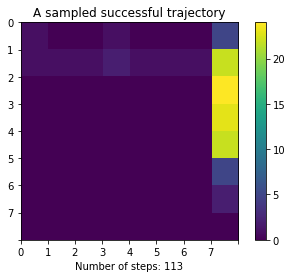

In [95]:
reward=0
count=0
while reward!=1:
    count+=1
    (history, reward )= shoot(environment,QTable,epsilon=0.0)

print("Iterations required :", count)
print("Number of steps: ", len(history))
plt.imshow(trajectory(history))
plt.colorbar()
plt.xticks(numpy.arange(-.5,size,1),numpy.arange(0,size,1))
plt.yticks(numpy.arange(-.5,size,1),numpy.arange(0,size,1))
plt.title("A sampled successful trajectory")
plt.xlabel("Number of steps: " + str(len(history)))
plt.show()

In [96]:
N = 3000
( success, steps) = testSuccessRate(QTable,environment, N)


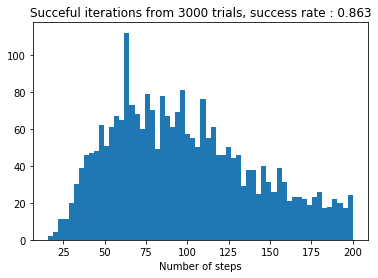

In [97]:
plt.hist(steps, bins = 60)
plt.title("Succeful iterations from " + str(N) + " trials, success rate : " + str(success/N))
plt.xlabel("Number of steps")
plt.show()